In [2]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Conv2D, Flatten, Dense

In [3]:
database = "/Users/rumen/Plovdiv University/Дипломна работа/InSAES_data"

In [4]:
# Extracting data
features, total_emotions = [], []

for x, _, z in os.walk(database):
    for i in z:
        if i.endswith(".wav"):
            audio_path = os.path.join(x, i)
            emotion = os.path.basename(x).split("_")[-1]
            audio, sr = librosa.load(audio_path, duration=3)
            mfcc = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13), axis=1)
            features.append(mfcc)
            total_emotions.append(emotion)

In [5]:
features = np.array(features)
total_emotions = np.array(total_emotions)

In [6]:
# Convert emotion names to numeric values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(total_emotions)

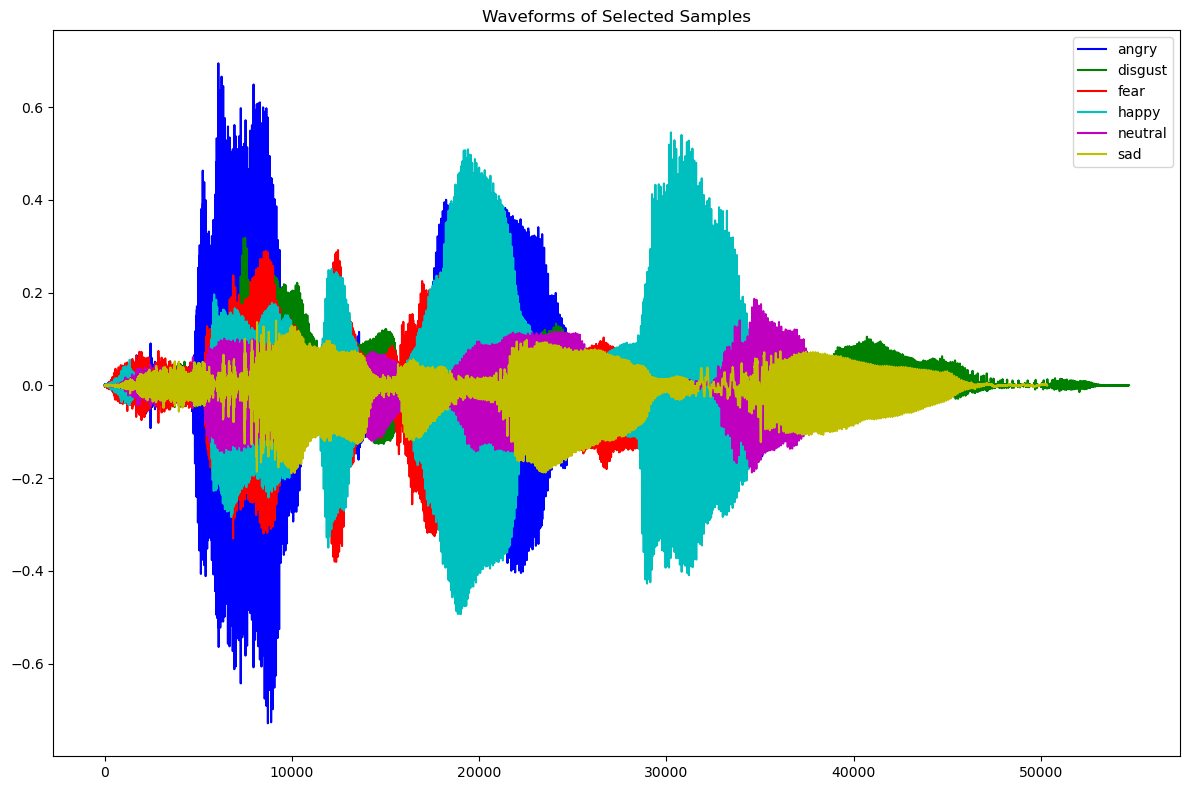

In [7]:
lst = []

for i in ["angry", "disgust", "fear", "happy", "neutral", "sad"]:
    curr_emotion_name = os.path.join(database, f"YAF_{i}")
    if os.path.exists(curr_emotion_name):

        random_data = np.random.choice([x for x in os.listdir(curr_emotion_name) if x.endswith(".wav")], size=3, replace=False)

        for k in random_data[:1]:
            file_path = os.path.join(curr_emotion_name, k)
            audio, sr = librosa.load(file_path, duration=3)
            lst.append((audio, sr, i))
    else:
        print(f"Directory {curr_emotion_name} does not exist")

# Visualising results
plt.figure(figsize=(12, 8))
for (audio, sr, emotion), i in zip(lst, ["b", "g", "r", "c", "m", "y", "k"]):
    plt.plot(audio, label=emotion, color=i)

plt.title("Waveforms of Selected Samples")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [8]:
def augment_audio(features_in, total_emotions_in):
    lst_f = []
    lst_e = []

    for f, e in zip(features_in, total_emotions_in):
        
        lst_f.append(f)
        lst_e.append(e)

        
        noise = np.random.randn(len(f))
        lst_f.append(f + 0.005 * noise)
        lst_e.append(e)

        
        lst_f.append(librosa.effects.time_stretch(f, rate=1.2))
        lst_e.append(e)

        
        lst_f.append(librosa.effects.pitch_shift(f, sr=22050, n_steps=2))
        lst_e.append(e)

    return np.array(lst_f), np.array(lst_e)


additional_features, augmented_t_emotions = augment_audio(features, total_emotions)

# Visualising the original and additional samples
print("Original samples:", len(features))
print("Current samples:", len(additional_features))

/Users/rumen/anaconda3/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=13
  warnings.warn(


Original samples: 2400
Current samples: 9600


/var/folders/9t/zg2tkg4d3xzcsndd1fts8v880000gn/T/ipykernel_3122/1387545356.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(lst_f), np.array(lst_e)


In [9]:
emotion_idxs = {"angry": 0, "disgust": 1, "fear": 2, "happy": 3, "neutral": 4, "sad": 5}
encoded_labels = np.array([emotion_idxs.get(x, -1) for x in total_emotions])


X_train, X_test, y_train, y_test = train_test_split(features[encoded_labels != -1],
                                                    encoded_labels[encoded_labels != -1], test_size=0.2, random_state=42)

X_train = X_train.reshape((*X_train.shape, 1))
X_test = X_test.reshape((*X_test.shape, 1))

# Convert the emotion labels to categorical format
y_train = to_categorical(y_train, len(emotion_idxs))
y_test = to_categorical(y_test, len(emotion_idxs))

In [10]:
# Creating CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(13, 1, 1), padding="same"))
# Convert the output to one-dimensional form
model.add(Flatten())
# Adding dense layer
model.add(Dense(32, activation="relu"))

model.add(Dense(6, activation="softmax"))
# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 13, 1, 32)         320       
                                                                 
 flatten (Flatten)           (None, 416)               0         
                                                                 
 dense (Dense)               (None, 32)                13344     
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                                                 
Total params: 13,862
Trainable params: 13,862
Non-trainable params: 0
_________________________________________________________________


2024-06-19 20:35:40.543821: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
history = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))

# Model evaluation
loss, accuracy = model.evaluate(X_test, y_test)

print("***********")
print("Test loss:", loss)
print("Test accuracy:", accuracy)

Epoch 1/10
30/30 [==============================] - 0s 5ms/step - loss: 3.7319 - accuracy: 0.3063 - val_loss: 1.5111 - val_accuracy: 0.5354
Epoch 2/10
30/30 [==============================] - 0s 2ms/step - loss: 1.0526 - accuracy: 0.6328 - val_loss: 0.7779 - val_accuracy: 0.7479
Epoch 3/10
30/30 [==============================] - 0s 2ms/step - loss: 0.6862 - accuracy: 0.8031 - val_loss: 0.5809 - val_accuracy: 0.8292
Epoch 4/10
30/30 [==============================] - 0s 2ms/step - loss: 0.5393 - accuracy: 0.8458 - val_loss: 0.4716 - val_accuracy: 0.8708
Epoch 5/10
30/30 [==============================] - 0s 2ms/step - loss: 0.4700 - accuracy: 0.8625 - val_loss: 0.4477 - val_accuracy: 0.8604
Epoch 6/10
30/30 [==============================] - 0s 2ms/step - loss: 0.4074 - accuracy: 0.8760 - val_loss: 0.3810 - val_accuracy: 0.8750
Epoch 7/10
30/30 [==============================] - 0s 2ms/step - loss: 0.3466 - accuracy: 0.8922 - val_loss: 0.3450 - val_accuracy: 0.8958
Epoch 8/10
30/30 [==

In [12]:
print("Accuracy of model on test data: " , model.evaluate(X_test,y_test)[1]*100 , "%")

15/15 [==============================] - 0s 761us/step - loss: 0.2983 - accuracy: 0.8917
Accuracy of our model on test data :  89.16666507720947 %


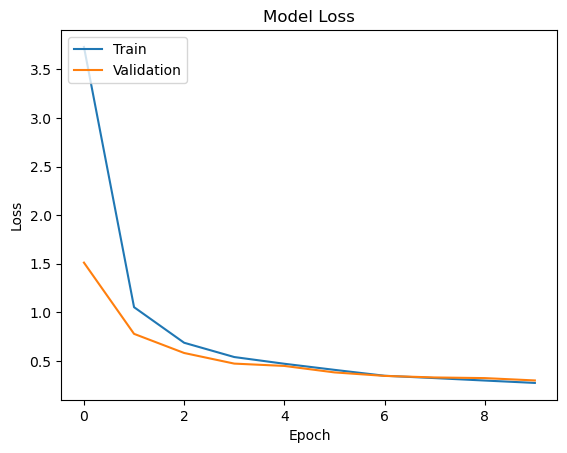

In [13]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

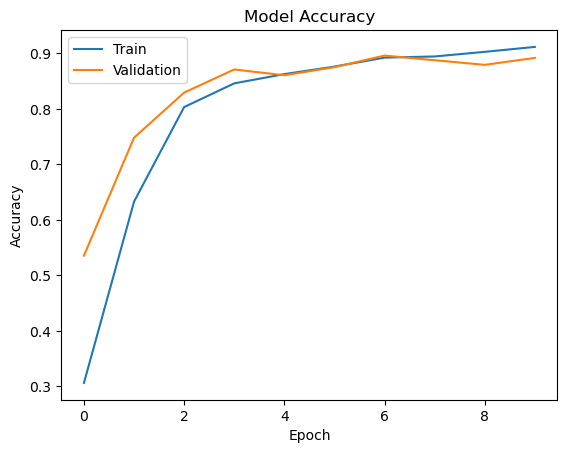

In [14]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

In [15]:
predicted_emotions = np.argmax(model.predict(X_test), axis=1)

true_emotions = np.argmax(y_test, axis=1)

report = classification_report(true_emotions, predicted_emotions, 
                               target_names=["angry", "disgust", "fear", "happy", "neutral", "sad"])
print(report)

15/15 [==============================] - 0s 820us/step
              precision    recall  f1-score   support

       angry       0.95      0.94      0.95        87
     disgust       0.86      0.92      0.89        74
        fear       0.82      0.87      0.84        68
       happy       0.96      0.88      0.92        85
     neutral       0.80      0.92      0.85        85
         sad       0.99      0.81      0.89        81

    accuracy                           0.89       480
   macro avg       0.90      0.89      0.89       480
weighted avg       0.90      0.89      0.89       480



In [16]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=10, batch_size=64)

Epoch 1/10
21/21 [==============================] - 0s 3ms/step - loss: 0.2831 - accuracy: 0.9122 - val_loss: 0.2466 - val_accuracy: 0.9253
Epoch 2/10
21/21 [==============================] - 0s 3ms/step - loss: 0.2568 - accuracy: 0.9189 - val_loss: 0.2571 - val_accuracy: 0.9045
Epoch 3/10
21/21 [==============================] - 0s 3ms/step - loss: 0.2360 - accuracy: 0.9256 - val_loss: 0.2072 - val_accuracy: 0.9392
Epoch 4/10
21/21 [==============================] - 0s 2ms/step - loss: 0.2222 - accuracy: 0.9353 - val_loss: 0.2088 - val_accuracy: 0.9375
Epoch 5/10
21/21 [==============================] - 0s 2ms/step - loss: 0.2200 - accuracy: 0.9338 - val_loss: 0.2272 - val_accuracy: 0.9184
Epoch 6/10
21/21 [==============================] - 0s 2ms/step - loss: 0.2260 - accuracy: 0.9293 - val_loss: 0.1989 - val_accuracy: 0.9323
Epoch 7/10
21/21 [==============================] - 0s 2ms/step - loss: 0.2102 - accuracy: 0.9263 - val_loss: 0.2123 - val_accuracy: 0.9271
Epoch 8/10
21/21 [==

In [17]:
print("Accuracy of model on train data: " , model.evaluate(X_train,y_train)[1]*100 , "%")

60/60 [==============================] - 0s 660us/step - loss: 0.1765 - accuracy: 0.9453
Accuracy of our model on train data :  94.53125 %


In [19]:
model.save("InSAES_model.h5")
print("Model saved correctly!")

Model saved correctly!
